## import packages

In [1]:
import MedorionDsTools.BigqueryUtils
import MedorionDsTools.Feateng
import MedorionDsTools.zips_data_call
import MedorionDsTools.Preprocessing
import MedorionDsTools.Modeling
import MedorionDsTools.Explain
import MedorionDsTools.Visual


/opt/conda/envs/mypy310/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [47]:
import importlib
importlib.reload(MedorionDsTools.Feateng)
importlib.reload(MedorionDsTools.BigqueryUtils)
importlib.reload(MedorionDsTools.zips_data_call)
importlib.reload(MedorionDsTools.Preprocessing)
importlib.reload(MedorionDsTools.Modeling)
importlib.reload(MedorionDsTools.Explain)
importlib.reload(MedorionDsTools.Visual)



<module 'MedorionDsTools.Visual' from '/home/jupyter/MedorionDsTools/MedorionDsTools/Visual.py'>

## fetch zip code  data 

In [17]:
us_zips =  MedorionDsTools.zips_data_call.load_uszips()
#load_uszips()

In [20]:
pharms_zips_uhg = MedorionDsTools.zips_data_call.load_uhg_zips()

## fetch members data 

In [3]:

members_features = MedorionDsTools.BigqueryUtils.table_to_df(table_name= "member_features",key_path="/home/jupyter/production-222406-91814fba4a29.json")

In [34]:
members = MedorionDsTools.BigqueryUtils.table_to_df(table_name= "members",key_path="/home/jupyter/production-222406-91814fba4a29.json")

In [4]:
gaps = MedorionDsTools.BigqueryUtils.table_to_df(table_name= "gaps_in_care",key_path="/home/jupyter/production-222406-91814fba4a29.json",last_snapshot=False)

In [5]:
rx_claims = MedorionDsTools.BigqueryUtils.table_to_df(table_name= "rx_claims",key_path="/home/jupyter/production-222406-91814fba4a29.json")

## Raw data processing

In [6]:
gaps = MedorionDsTools.Preprocessing.gaps_processing(gaps)

In [7]:
rx_claims = MedorionDsTools.Preprocessing.rx_claims_processing(rx_claims)

## New featurs to add to (example)

the following code is for extra features such as :

    + copay percent of drug cost, 
    + weighted copay percent of drug cost
    + drug tier
    + preferred drug change 
    + first compliant date
    + last compliant date
    + first compliance value
    + last compliance value
    + max allowable days remaining


In [8]:
rx_claims_features = MedorionDsTools.Feateng.rx_claims_feature_extraction(rx_claims)

In [9]:
gaps_features =  MedorionDsTools.Feateng.gaps_feature_extraction(gaps)

##  Merge new features with old features 

    + Note that we are choosing members in the "MAC" measure 

In [11]:
df =MedorionDsTools.Feateng.merge_features([gaps_features.loc[gaps_features.measure_id  == "MAC",:],
rx_claims_features,members_features])

## Save and run locally(Ignore)

In [11]:
# save rx_claims to parquet file
df.to_parquet("/home/jupyter/MedorionDsTools/MedorionDsTools/data/df_feats.parquet")


In [12]:
from pandas import read_parquet
# read rx_claims from parquet file
df = read_parquet("/home/jupyter/MedorionDsTools/MedorionDsTools/data/df_feats.parquet")


## modeling Prepare - Exam The data And Label it 

    + Define  a proxy label 
    + Define the label name 

In [12]:
df['compliance_direction'] = (df['compliance_value_last'] - df['compliance_value_first'])

In [14]:
df = df[df["compliance_direction"].notnull() & (df["compliance_direction"]!=0)]
label_for_modeling = "adhernce_direction"

Look at the distribution to build labels 

    + select two groups of with margin between them 
    + make the selection  
    + label each one of them 
    


<Axes: >

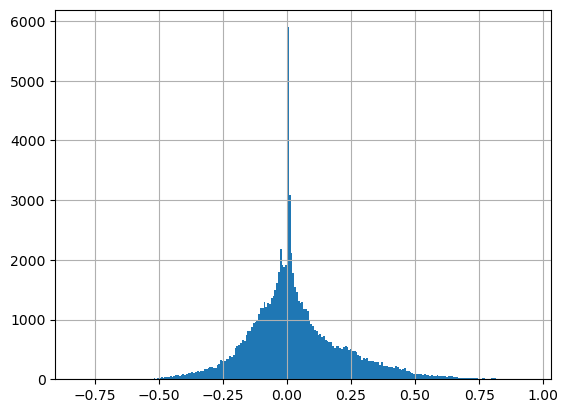

In [15]:
df.compliance_direction.hist(bins=250)

In [16]:
df.loc[df.compliance_direction>=0.15,label_for_modeling] = 1 # adherent in statins
df.loc[df.compliance_direction<=-0.15,label_for_modeling] = 0 # no adherent in statins
    

+ print the label proportions 

In [17]:
df[label_for_modeling].value_counts(False)

1.0    19218
0.0    11577
Name: adhernce_direction, dtype: int64

## Choose the features to be used in the model

    + In order to build a model there is a need to transfer categorial features to dummy features 
    + you can see the categorial features with the code

```python

MedorionDsTools.Preprocessing.print_features(df)

``` 

In [18]:

categorical_features = [
 'gender',
 'race']


In [19]:
df = MedorionDsTools.Preprocessing.categorical_encoding(df,categorical_features)

## Preprocessing  the features before modeling

    + print all the featuress in the dataframe in order  to select which features to include in the model 
    + insert your selection to  lists 

In [20]:
MedorionDsTools.Preprocessing.print_features(df)


categorical features :
Index(['member_id', 'measure_id', 'first_pharmacy_zip', 'last_pharmacy_zip',
       'org_code', 'compliance_value'],
      dtype='object')

numerical features :
Index(['compliance_value_first', 'compliance_value_last',
       'allowable_days_remaining_mean', 'allowable_days_remaining_max',
       'allowable_days_remaining_min', 'member_id_count', 'copay_percent',
       'copay_percent_weighted', 'first_patient_co_pay', 'last_patient_co_pay',
       'first_drug_cost', 'last_drug_cost', 'unique_pharmacy_zip_count',
       'drug_tier', 'preferred_drug_change_sum', 'days_between_rx_fill',
       'diff_in_first_last_copay', 'diff_in_first_last_drug_cost',
       'diff_in_first_last_patient_co_pay', 'lis', 'age', 'tenure', 'density',
       'married', 'family_size', 'income_household_median', 'home_ownership',
       'home_value', 'rent_median', 'education_college_or_above',
       'unemployment_rate', 'tier3_usage', 'rasa_last_pdc', 'statins_last_pdc',
       'diabet

In [30]:

categorical_features = []
numerical_features = [
      #  'compliance_value_first', 
      #  'allowable_days_remaining_mean',
      #  'allowable_days_remaining_max',
      #  'allowable_days_remaining_min',
      #  'member_id_count',
       'copay_percent',
       'copay_percent_weighted', 'first_patient_co_pay', 'last_patient_co_pay',
       'first_drug_cost', 'last_drug_cost', 'unique_pharmacy_zip_count',
       'drug_tier', 'preferred_drug_change_sum', 'days_between_rx_fill',
       'diff_in_first_last_copay', 'diff_in_first_last_drug_cost',
       'diff_in_first_last_patient_co_pay', 'lis', 'age', 'tenure', 'density',
       'married', 'family_size', 'income_household_median', 'home_ownership',
       'home_value', 'rent_median', 'education_college_or_above',
       'unemployment_rate', 'tier3_usage', 'rasa_last_pdc', 
      #  'statins_last_pdc',
      'spc_last_pdc', 'supd_last_pdc', 'has_diabetes',
       'has_diabetes_class_sulfonylureas', 'has_rasa_hypertension',
       'has_rasa_ht_diuretics', 'has_rasa_ht_arbs',
       'has_rasa_ht_ace_inhibitors', 'has_rasa_ht_direct_renin_inhibitors',
       'has_rasa_ht_thiazide_diuretics', 'has_rasa_ht_loop_diuretics',
       'has_rasa_ht_potassium_sparing_diuretics', 'has_rasa_ht_beta_blockers',
       'has_rasa_ht_ccb_dihydropyridines',
       'has_rasa_ht_ccb_nondihydropyridines', 'has_rasa_ht_alpha_blockers',
       'has_rasa_ht_combined_alpha_and_bbs', 'has_rasa_ht_central_agonists',
       'has_rasa_ht_peripheral_adrenergic_inhibitors',
       'has_rasa_ht_aldosterone_receptor_blockers',
       'has_rasa_ht_bb_with_intrinsic_sympathomimetic_activity',
       'has_rasa_ht_direct_vasodilators', 'has_cholesterol',
       'has_statins_cholesterol', 'has_bile_acid_sequestrants_cholesterol',
       'has_absorption_inhibitor_cholesterol', 'has_niacin_cholesterol',
       'has_pcsk9_inhibitors_cholesterol', 'has_acl_inhibitors_cholesterol',
       'has_fibrates_cholesterol', 'has_omega3_acids_cholesterol',
       'has_liver_cirrhosis', 'has_chronic_kidney_disease',
       'has_thyroid_disease_drugs', 'has_pain_relief', 'has_obesity',
       'has_depression', 'has_anti_smoking', 'has_asthma', 'number_of_cc',
       'dist', 'day_of_refill', 'max_copay', 'avg_copay', 'total_copay',
       'has_metformin', 'dosage_level_statins', 'dosage_level_diabetes',
       'dosage_level_rasa', 'drug_count', 'days_100', 'gender_M', 'race_B', 'race_H', 'race_N',
       'race_O', 'race_U', 'race_W'
 ]

## Modeling

    + Prepere for Modeling 
    + Call the Model 

In [31]:
modeling_obj = MedorionDsTools.Preprocessing.modeling_prepare(df,label_for_modeling,categorical_features , numerical_features)

In [33]:
model = MedorionDsTools.Modeling.train_model(modeling_obj = modeling_obj,model_type = 'xgboost',hyper_params={
            "eta": 0.5,
            "max_depth": 8,
            "objective": "binary:logistic",
            "silent": 1,
            # "subsample": 1,
            # "base_score": np.mean(modeling_obj['y_train']),
            "scale_pos_weight" :modeling_obj['y_train'].value_counts()[0]/modeling_obj['y_train'].value_counts()[1],
            "eval_metric": "auc"
        })

Pass `evals` as keyword args.


[11:20:16] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-auc:0.85887	test-auc:0.64460
[1]	train-auc:0.87912	test-auc:0.76799
[2]	train-auc:0.88846	test-auc:0.74494
[3]	train-auc:0.89965	test-auc:0.77306
[4]	train-auc:0.90668	test-auc:0.77921
[5]	train-auc:0.91265	test-auc:0.78308
[6]	train-auc:0.91632	test-auc:0.78622
[7]	train-auc:0.92100	test-auc:0.78697
[8]	train-auc:0.92307	test-auc:0.78678
[9]	train-auc:0.92923	test-auc:0.78695
[10]	train-auc:0.93256	test-auc:0.78601
[11]	train-auc:0.93633	test-auc:0.78218
[12]	train-auc:0.93880	test-auc:0.78213
[13]	train-auc:0.94208	test-auc:0.78139
[14]	train-auc:0.94352	test-auc:0.78097
[15]	train-auc:0.95055	test-auc:0.77788
[16]	train-auc:0.95234	test-auc:0.77763
[17]	train-auc:0.95506	test-auc:0.77531


##  Shap values Extarction and Visualization

    + transform the data to their shap values

In [48]:
shap_obj =  MedorionDsTools.Explain.shap_extraction(model,modeling_obj)

In [34]:
shap_values_train_df =  shap_obj[0]

In [50]:
shap_model =  shap_obj[1]

## Dimensionality reduction and Visual

    + reduce the shap values data frame in to 2 dimensional data

In [59]:
shap_values_df_embedded_train = MedorionDsTools.Explain.umap_extraction(shap_values_train_df) 

    + add the label to the reduced dataframe

In [60]:
df = MedorionDsTools.Explain.add_label_to_df(shap_values_df_embedded_train, modeling_obj['y_train'])


    + visual the embedding of shap values with the label

<Axes: xlabel='UMAP 1', ylabel='UMAP 2'>

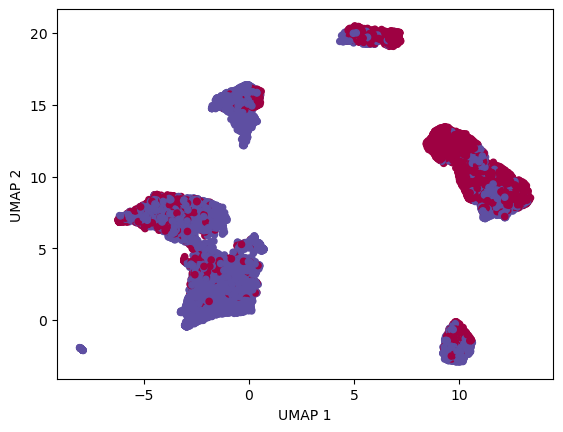

In [61]:

MedorionDsTools.Visual.scatter_plot_umap(df)

## Kmeans clustering for sahp values

In [65]:
clusters = MedorionDsTools.Explain.clusters_extraction(df,n_clusters= 6)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [66]:
df = MedorionDsTools.Explain.add_label_to_df(shap_values_df_embedded_train, clusters.labels_)


<Axes: xlabel='UMAP 1', ylabel='UMAP 2'>

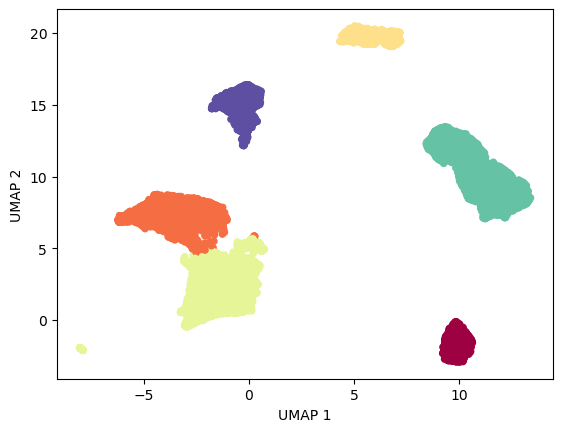

In [67]:

MedorionDsTools.Visual.scatter_plot_umap(df)

## Clustering exploration

In [87]:

modeling_obj['X_train']["cluster"] = clusters.labels_
# for each cluster, we will calculate the mean of values of each feature
cluster_mean = modeling_obj['X_train'].groupby(['cluster']).mean()
# for each cluster give the count of observations
cluster_count = modeling_obj['X_train'].groupby(['cluster']).size()
# for each cluster, we will calculate the summery statistics of values of each feature
cluster_summary = modeling_obj['X_train'].groupby(['cluster']).agg(['min', 'max', 'mean', 'median'])
# predict teh model on the cluster means
cluster_preds = MedorionDsTools.Modeling.predict_model(cluster_mean, model=model)
shap_values_cluster_mean = shap_model.shap_values(cluster_mean,check_additivity=False)

# cluster_summary

In [76]:
shap_values_cluster_mean = shap_model.shap_values(cluster_mean,check_additivity=False)


Cluster:  0

Cluster count:  1629

Prediction:  0.15523575

Shap values: 



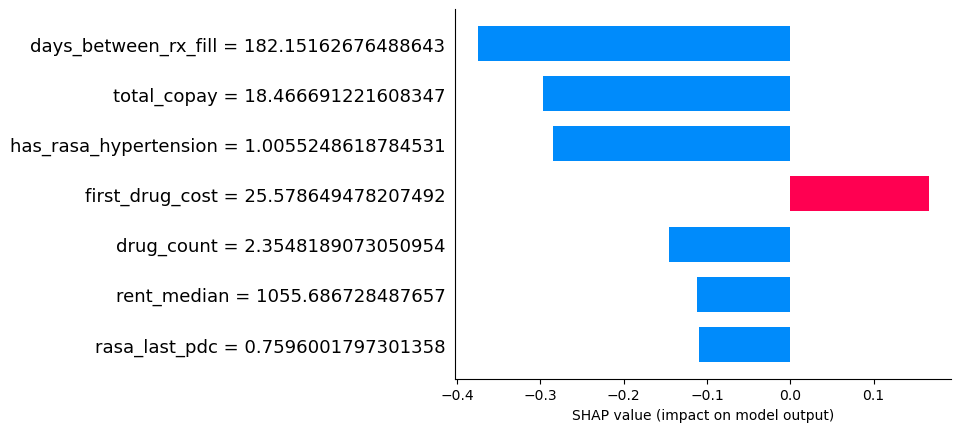

Cluster summary: 

copay_percent           min       0.000000
                        max       1.000000
                        mean      0.157414
                        median    0.000000
copay_percent_weighted  min       0.000000
                                    ...   
race_U                  median    0.000000
race_W                  min       0.000000
                        max       1.000000
                        mean      0.689380
                        median    1.000000
Name: 0, Length: 340, dtype: float64

Cluster:  1

Cluster count:  4057

Prediction:  0.5119366

Shap values: 



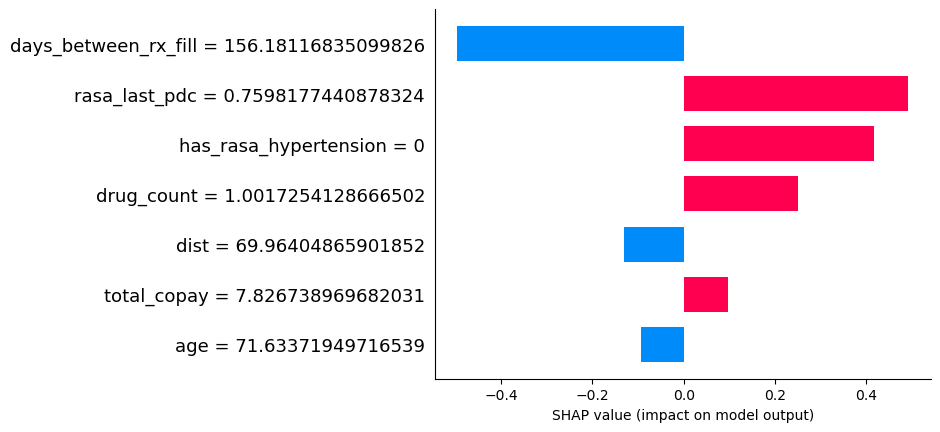

Cluster summary: 

copay_percent           min       0.000000
                        max       1.000000
                        mean      0.257647
                        median    0.000000
copay_percent_weighted  min       0.000000
                                    ...   
race_U                  median    0.000000
race_W                  min       0.000000
                        max       1.000000
                        mean      0.711363
                        median    1.000000
Name: 1, Length: 340, dtype: float64

Cluster:  2

Cluster count:  1337

Prediction:  0.07704899

Shap values: 



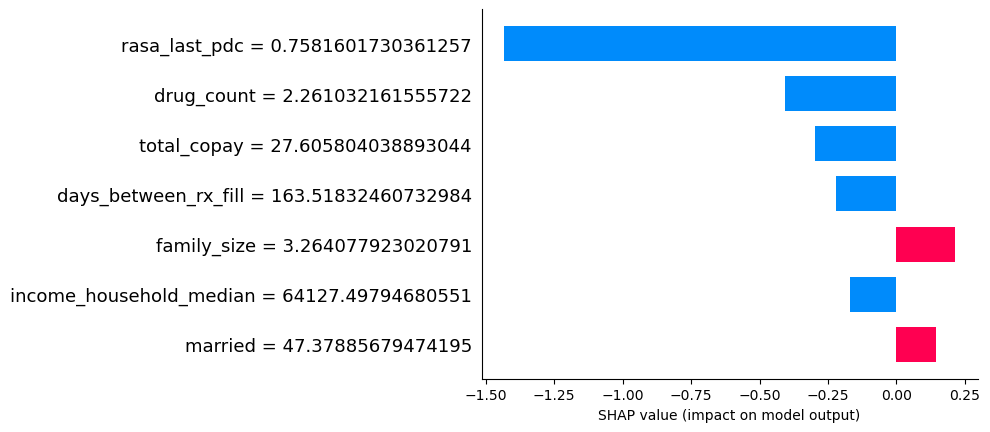

Cluster summary: 

copay_percent           min       0.000000
                        max       1.000000
                        mean      0.228884
                        median    0.000000
copay_percent_weighted  min       0.000000
                                    ...   
race_U                  median    0.000000
race_W                  min       0.000000
                        max       1.000000
                        mean      0.623037
                        median    1.000000
Name: 2, Length: 340, dtype: float64

Cluster:  3

Cluster count:  6066

Prediction:  0.57969004

Shap values: 



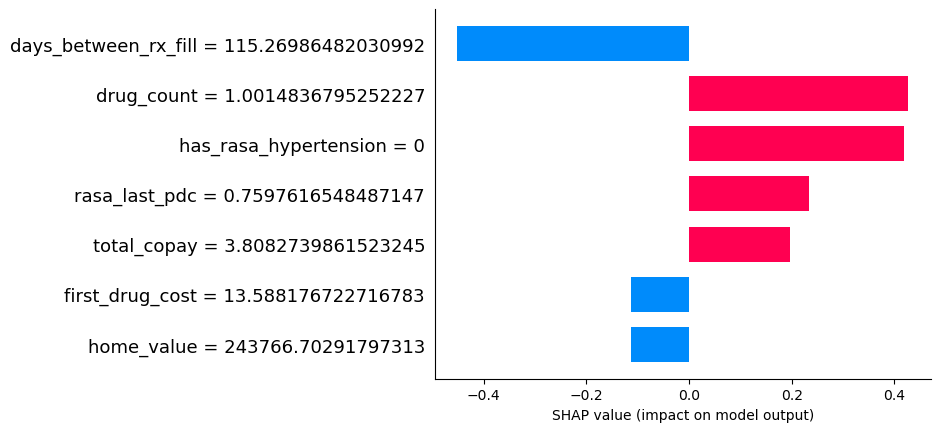

Cluster summary: 

copay_percent           min       0.000000
                        max       1.000000
                        mean      0.249527
                        median    0.000000
copay_percent_weighted  min       0.000000
                                    ...   
race_U                  median    0.000000
race_W                  min       0.000000
                        max       1.000000
                        mean      0.697989
                        median    1.000000
Name: 3, Length: 340, dtype: float64

Cluster:  4

Cluster count:  6065

Prediction:  0.18552841

Shap values: 



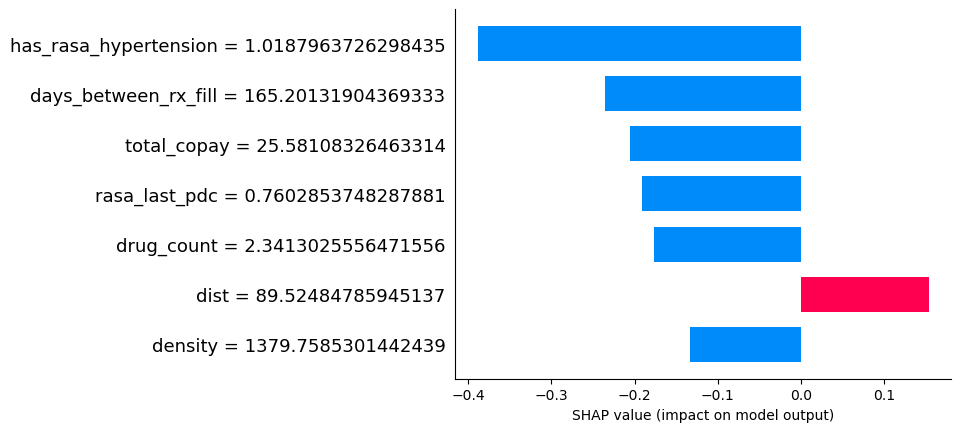

Cluster summary: 

copay_percent           min       0.000000
                        max       1.000000
                        mean      0.224747
                        median    0.000000
copay_percent_weighted  min       0.000000
                                    ...   
race_U                  median    0.000000
race_W                  min       0.000000
                        max       1.000000
                        mean      0.713932
                        median    1.000000
Name: 4, Length: 340, dtype: float64

Cluster:  5

Cluster count:  2402

Prediction:  0.685381

Shap values: 



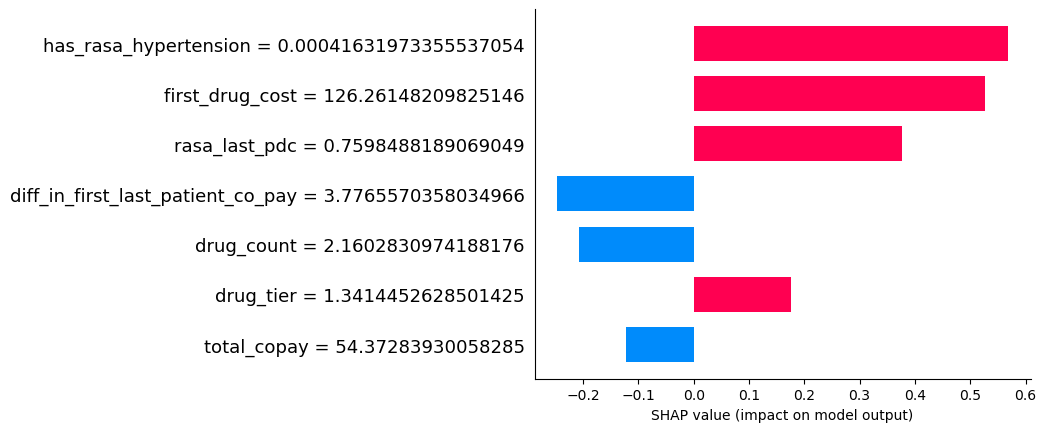

Cluster summary: 

copay_percent           min       0.000000
                        max       1.000000
                        mean      0.185255
                        median    0.002593
copay_percent_weighted  min       0.000000
                                    ...   
race_U                  median    0.000000
race_W                  min       0.000000
                        max       1.000000
                        mean      0.641549
                        median    1.000000
Name: 5, Length: 340, dtype: float64



In [88]:
import shap 

for i in range(6):
    print("Cluster: ",i)
    # print new line
    print()
    # print cluster count
    print("Cluster count: ",cluster_count[i])
    # print new line
    print()
    # print prediction
    print("Prediction: ",cluster_preds[i])
    # print new line
    print()
    #print shap values
    print("Shap values: \n")
    shap.bar_plot(shap_values = shap_values_cluster_mean[i],  features=cluster_mean.values[i],feature_names=cluster_mean.columns)
    #print cluster summary
    print("Cluster summary: \n")
    print(cluster_summary.iloc[i,:])
    # print new line
    print()